In [1]:
import sys
sys.path.insert(1, '/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101')
import pathlib
import os
from scripts import dataset_setup, model_setup, utilities
import torchvision
from torch.mps import is_available
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchinfo
from time import time
import numpy as np

In [2]:
model = model_setup.EffNetB4(name='EfficientNetB4')

In [3]:
torchinfo.summary(model,
                  input_size=(1, 3, 256, 256),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable']
                  )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EffNetB4                                 [1, 3, 256, 256]          [1, 1000]                 --                        True
├─ModuleList: 1-1                        --                        --                        --                        True
│    └─Sequential: 2-1                   [1, 3, 256, 256]          [1, 1792, 8, 8]           17,548,616                True
│    └─Conv2dNormActivation: 2-2         [1, 3, 256, 256]          [1, 48, 128, 128]         1,392                     True
│    └─Conv2d: 2-3                       [1, 3, 256, 256]          [1, 48, 128, 128]         1,296                     True
│    └─BatchNorm2d: 2-4                  [1, 48, 128, 128]         [1, 48, 128, 128]         96                        True
│    └─SiLU: 2-5                         [1, 48, 128, 128]         [1, 48, 128, 128]         --                        --
│    

In [4]:
device = 'mps' if is_available() else 'cpu'
model.to(device)


EffNetB4(
  (architecture): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
                (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        

In [5]:
for param in model.features.parameters():
    param.requires_grad = False

In [6]:
torchinfo.summary(model,
                  input_size=(1, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable']
                  )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EffNetB4                                 [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─ModuleList: 1-1                        --                        --                        --                        Partial
│    └─Sequential: 2-1                   [1, 3, 224, 224]          [1, 1792, 7, 7]           17,548,616                False
│    └─Conv2dNormActivation: 2-2         [1, 3, 224, 224]          [1, 48, 112, 112]         1,392                     False
│    └─Conv2d: 2-3                       [1, 3, 224, 224]          [1, 48, 112, 112]         (1,296)                   False
│    └─BatchNorm2d: 2-4                  [1, 48, 112, 112]         [1, 48, 112, 112]         (96)                      False
│    └─SiLU: 2-5                         [1, 48, 112, 112]         [1, 48, 112, 112]         --                      

In [7]:
#checking the dimension of the output of the model down to the avgpooling layer, in order to set properly the head of the model when it comes to talk of transfer learning
model.classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)

In [8]:
model.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(in_features=1792, out_features=5, bias=True)
)
model.classifier.to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1792, out_features=5, bias=True)
)

In [9]:
torchinfo.summary(model,
                  input_size=(1, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable']
                  )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EffNetB4                                 [1, 3, 224, 224]          [1, 5]                    --                        Partial
├─ModuleList: 1-1                        --                        --                        --                        Partial
│    └─Sequential: 2-1                   [1, 3, 224, 224]          [1, 1792, 7, 7]           17,548,616                False
│    └─Conv2dNormActivation: 2-2         [1, 3, 224, 224]          [1, 48, 112, 112]         1,392                     False
│    └─Conv2d: 2-3                       [1, 3, 224, 224]          [1, 48, 112, 112]         (1,296)                   False
│    └─BatchNorm2d: 2-4                  [1, 48, 112, 112]         [1, 48, 112, 112]         (96)                      False
│    └─SiLU: 2-5                         [1, 48, 112, 112]         [1, 48, 112, 112]         --                      

In [10]:
#the default folder to save new models and the log
MODEL_FOLDER = pathlib.Path(os.getcwd() + '/saved_models/new_model')
LOG_FOLDER = MODEL_FOLDER
FOOD101_PATH = pathlib.Path(os.getcwd() + '/Datasets/food-101') #folder where the original dataset is stored in the  
DATASET_TRAIN_FOLDER = pathlib.Path(os.getcwd() + '/Datasets/train')
DATASET_TEST_FOLDER = pathlib.Path(os.getcwd() + '/Datasets/test')

NUMBER_OF_CLASSES = 5 #number of classes to use for the training
BATCH_SIZE = 2 ** 5
LEARNING_RATE = 5e-3
#setting up a logger Agent
logger = utilities.Logging_Agent(LOG_FOLDER)

In [11]:
pre_trained_transform = torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()

train_dataset = ImageFolder(DATASET_TRAIN_FOLDER,
                            transform=pre_trained_transform)
test_dataset = ImageFolder(DATASET_TEST_FOLDER,
                           transform=pre_trained_transform)
train_batches = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/06_PyTorch_TransferLearning/Datasets/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )

In [13]:
logger.write_log(f'The DataLoaders are up and ready!\n\tClasses: {train_dataset.class_to_idx}')

The DataLoaders are up and ready!
	Classes: {'cup_cakes': 0, 'french_fries': 1, 'pizza': 2, 'steak': 3, 'sushi': 4}


In [14]:
model.to(device)
print(f'The model is on: {next(iter(model.parameters())).device}')

The model is on: mps:0


In [15]:
import torch
#testing the model functionality with the first picture in the dataloader. Just to see whether the outcome is consistent with what we expect or not:
test_pic = next(iter(train_batches))[0][0].unsqueeze(dim=0).to(device=device)
print(f'The dummy tensor is on: {test_pic.device}')
print(f'The model is on: {next(iter(model.parameters())).device}')

model.eval()
with torch.no_grad():
    outcome_test = model(test_pic)

logger.write_log(f'The outcome of the tast performed on the first picture fetched from the dataloader is: '
      f'\n\tLOGITS: {outcome_test}'
      f'\n\tPROBABILITIES: {torch.softmax(outcome_test, dim=1)}'
      f'\n\tPREDICTED CLASS: {torch.argmax(torch.softmax(outcome_test, dim=1), dim=1).item()}')

The dummy tensor is on: mps:0
The model is on: mps:0
The outcome of the tast performed on the first picture fetched from the dataloader is: 
	LOGITS: tensor([[ 0.0637, -0.0807,  0.0050,  0.0084, -0.0872]], device='mps:0')
	PROBABILITIES: tensor([[0.2167, 0.1876, 0.2044, 0.2050, 0.1864]], device='mps:0')
	PREDICTED CLASS: 0


In [16]:
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

logger.write_log(f'The Learning Rate is set to {LEARNING_RATE} | Optimizer is on and ready...')

The Learning Rate is set to 0.005 | Optimizer is on and ready...


In [17]:
from tqdm.auto import tqdm
epochs = 0
end_epochs = 100

start_time = time()
for epoch in range(epochs, end_epochs):
    logger.write_log(f'EPOCH NUMBER: {epoch + 1} out of {end_epochs}')
    train_loss = []
    cv_loss = []
    train_acc = []
    cv_acc = []
    start_time_epoch = time() #marking the starting time for the epoch training
    for batch_index, (batch_X, batch_y) in enumerate(train_batches):
        
        start_time_batch = time()
        
        #training step per every batch. the function returns the loss and accuracy
        model.train() #switches on the train mode from torch module
        loss_batch, acc_batch = model.train_step(batch_X=batch_X, 
                                                  batch_y=batch_y,
                                                  optimizer=optimizer, 
                                                  loss_foo=ce_loss,
                                                  device=device)

        #appending the losses computed for the batch to the container for the whole epoch
        train_loss.append(loss_batch)
        train_acc.append(acc_batch)
        
        end_time_batch = time()
        
        if batch_index % 50 == 0:
            resume_batch = model.write_minibatch_results_class(
                batch_index=batch_index,
                batch_quantity=len(train_batches),
                train_loss=train_loss,
                batch_loss_train=loss_batch,
                train_acc=train_acc,
                batch_acc_train=acc_batch,
                start_time_iteration=start_time_batch,
                end_time_iteration=end_time_batch
            )
            logger.write_log(resume_batch)
            
    #5. CrossValidation step (once per epoch...)
    model.eval()
    for batch_test_X, batch_test_y in test_batches:
        loss_batch_cv, acc_batch_cv = model.eval_step(
            batch_test_X=batch_test_X,
            batch_test_y=batch_test_y,
            loss_foo=ce_loss,
            device=device
        )
            
        #appending the losses computed for the batch to the container for the whole epoch
        cv_loss.append(loss_batch_cv)
        cv_acc.append(acc_batch_cv)
        
    #marking the end time for the epoch training
    end_time_epoch = time()
    epoch_resume = model.write_epoch_results_class(
        curr_iteration=epoch,
        last_iteration=end_epochs,
        train_loss=train_loss,
        train_acc=train_acc,
        cv_loss=cv_loss,
        cv_acc=cv_acc,
        end_time_iteration=end_time_epoch,
        start_time_iteration=start_time_epoch
    )
    logger.write_log(epoch_resume)

    #keep track of the history of the training metrics
    model.history_update('train_loss', np.mean(train_loss).item())
    model.history_update('train_acc', np.mean(train_acc).item())
    model.history_update('cv_loss', np.mean(cv_loss).item())
    model.history_update('cv_acc', np.mean(cv_acc).item())
    
    if epoch % 20 == 0 & epoch != 0:
        utilities.save_model(
            path=MODEL_FOLDER,
            model=model,
            optimizer=optimizer,
            epoch_nr=end_epochs,
            learning_rate=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            nr_classes=NUMBER_OF_CLASSES
        )
        logger.write_log(f'Model and optimizer saved for the checkpoint @epoch nr.: {epoch}')

end_time = time()
utilities.save_model(
    path=MODEL_FOLDER,
    model=model,
    optimizer=optimizer,
    epoch_nr=end_epochs,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    nr_classes=NUMBER_OF_CLASSES
)

EPOCH NUMBER: 1 out of 100
Intermediate results for batch 000 out of 125: Train Loss epoch:    1.620 (last:    1.620) | Train Acc. epoch: 15.62% (last: 15.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 050 out of 125: Train Loss epoch:    1.576 (last:    1.541) | Train Acc. epoch: 36.03% (last: 46.88%) | Elapsed Time: 0.2 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    1.546 (last:    1.483) | Train Acc. epoch: 47.31% (last: 71.88%) | Elapsed Time: 0.2 sec.
Epoch number: 1 out of 100
	Train loss: 1.534 | Train Accuracy: 50.825%
	CV loss:    1.472 | CV Accuracy:    74.023%
	Time taken: 42.58 seconds
EPOCH NUMBER: 2 out of 100
Intermediate results for batch 000 out of 125: Train Loss epoch:    1.411 (last:    1.411) | Train Acc. epoch: 87.50% (last: 87.50%) | Elapsed Time: 0.2 sec.
Intermediate results for batch 050 out of 125: Train Loss epoch:    1.435 (last:    1.386) | Train Acc. epoch: 74.33% (last: 84.38%) | Elapsed Time: 0.2 sec.
Intermediate

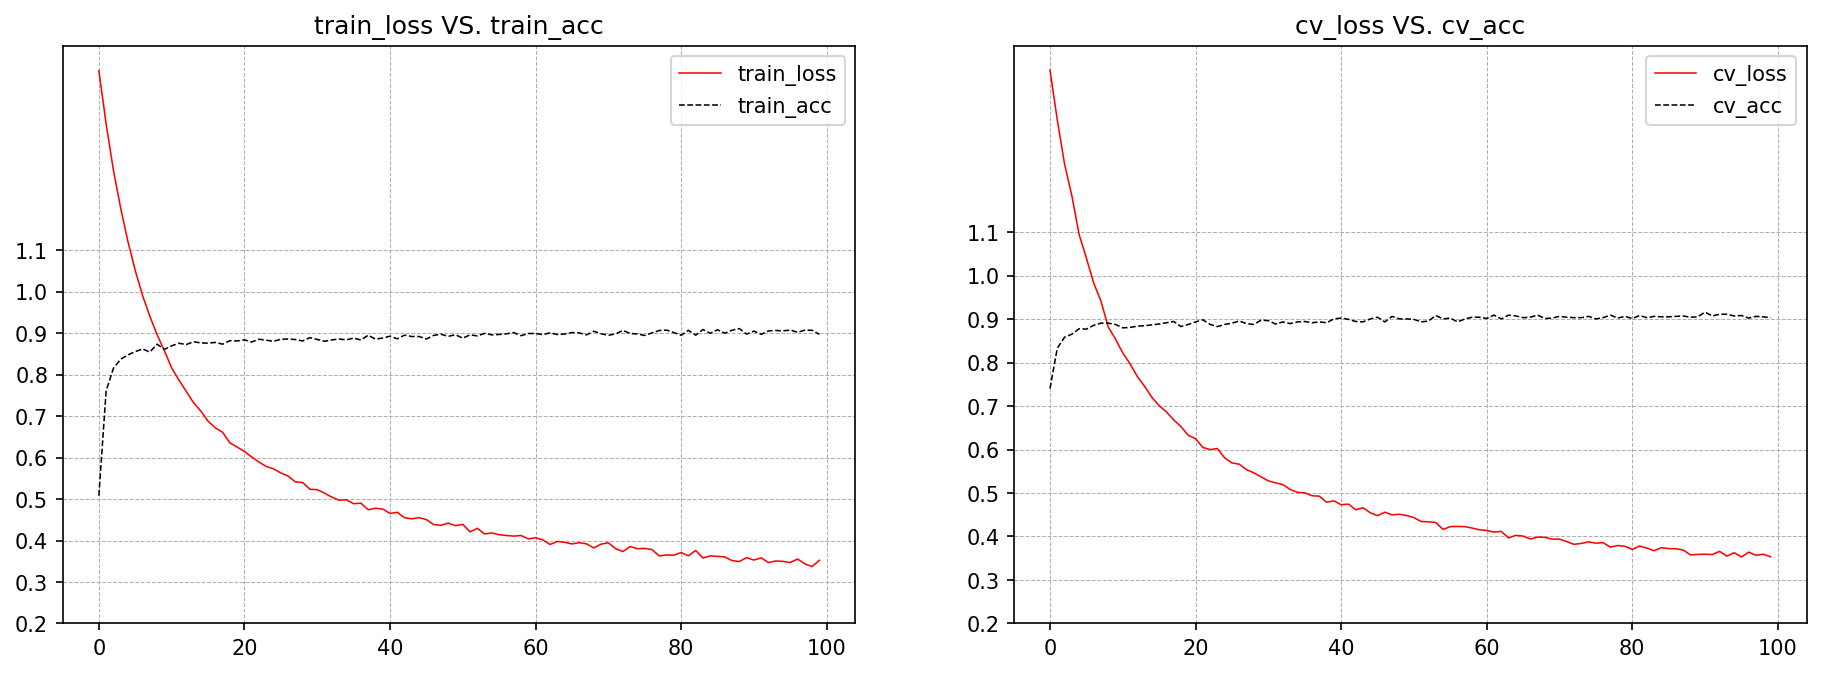

In [19]:
import matplotlib.pyplot as plt
metrics = [('train_loss', 'train_acc'),
           ('cv_loss', 'cv_acc')]

fig = plt.figure(figsize=[15, 5], dpi=150)
for index, (loss, acc) in enumerate(metrics):
    fig.add_subplot(1, 2, index + 1)
    plt.plot(
        np.arange(len(model.history[loss])),
        model.history[loss],
        label=loss,
        color='red',
        linewidth = 0.75,
    )
    plt.plot(
        np.arange(len(model.history[loss])),
        model.history[acc],
        label = acc,
        color='black',
        linewidth = 0.75,
        linestyle='--'
    )
    plt.legend()
    plt.title(f'{loss } VS. {acc}')
    plt.yticks(np.arange(0.2, 1.2, 0.1))
    plt.grid(linestyle='--', linewidth=0.5)
plt.savefig(MODEL_FOLDER / 'loss_acc_history.jpg')

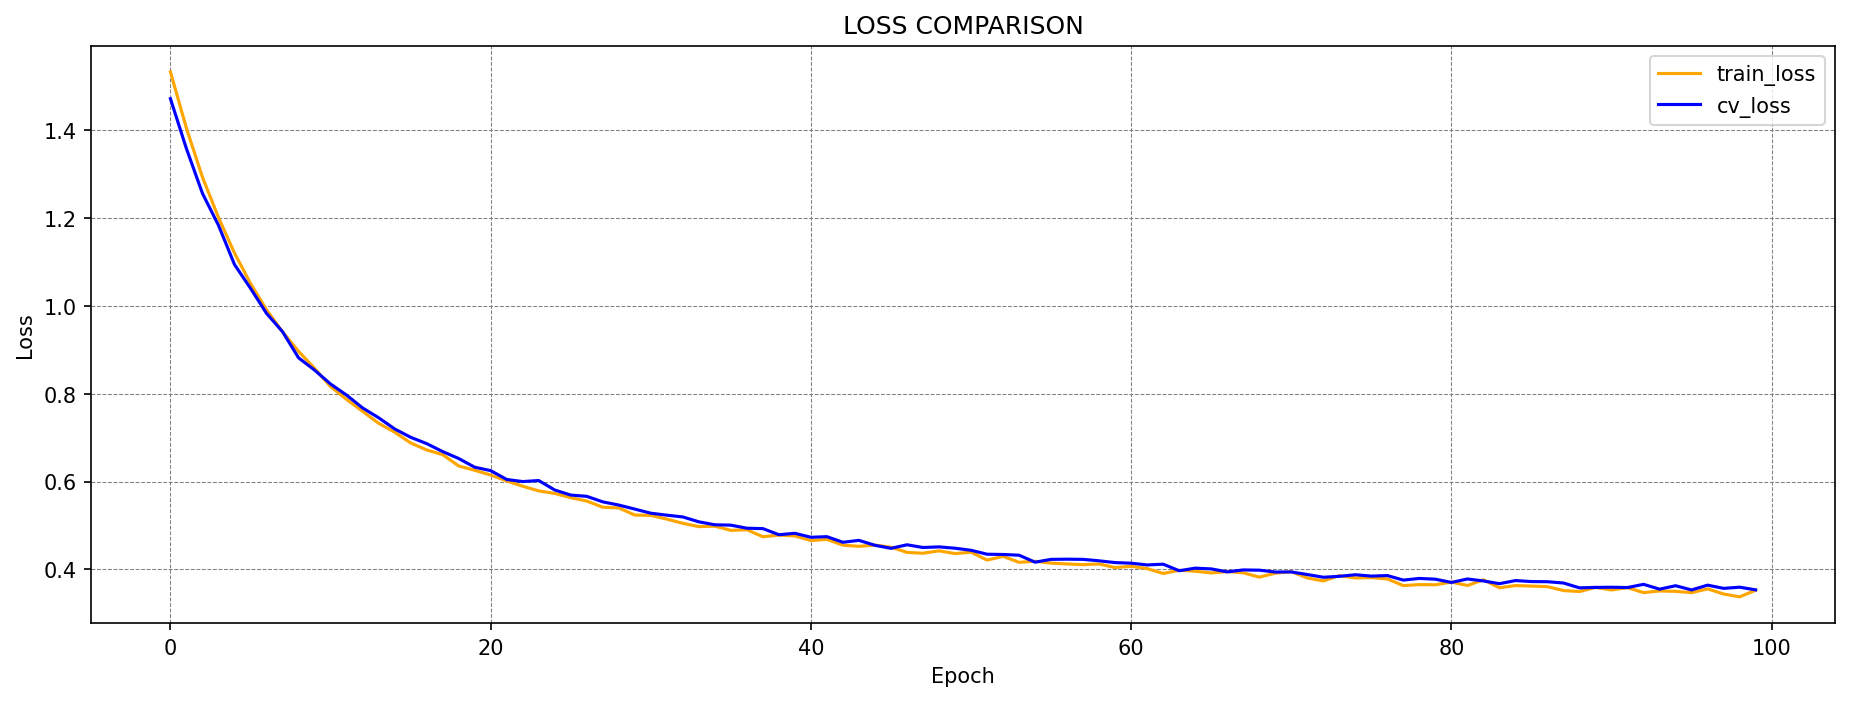

In [20]:
fig = plt.figure(figsize=[15, 5], dpi=150)
plt.plot(np.arange(len(model.history[loss])), model.history['train_loss'], color='orange', label='train_loss')
plt.plot(np.arange(len(model.history[loss])), model.history['cv_loss'], color='blue', label='cv_loss')
plt.title('LOSS COMPARISON')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(linewidth='.5', linestyle='--', color='gray')
plt.savefig(MODEL_FOLDER / 'loss_comparison.jpg')

In [34]:
from numpy import polyfit, arange
period = 0
period2 = 10
polyfit(x=arange(period2-period), y=model.history['cv_loss'][period:period2], deg=1)

array([-0.06747818,  1.41036015])

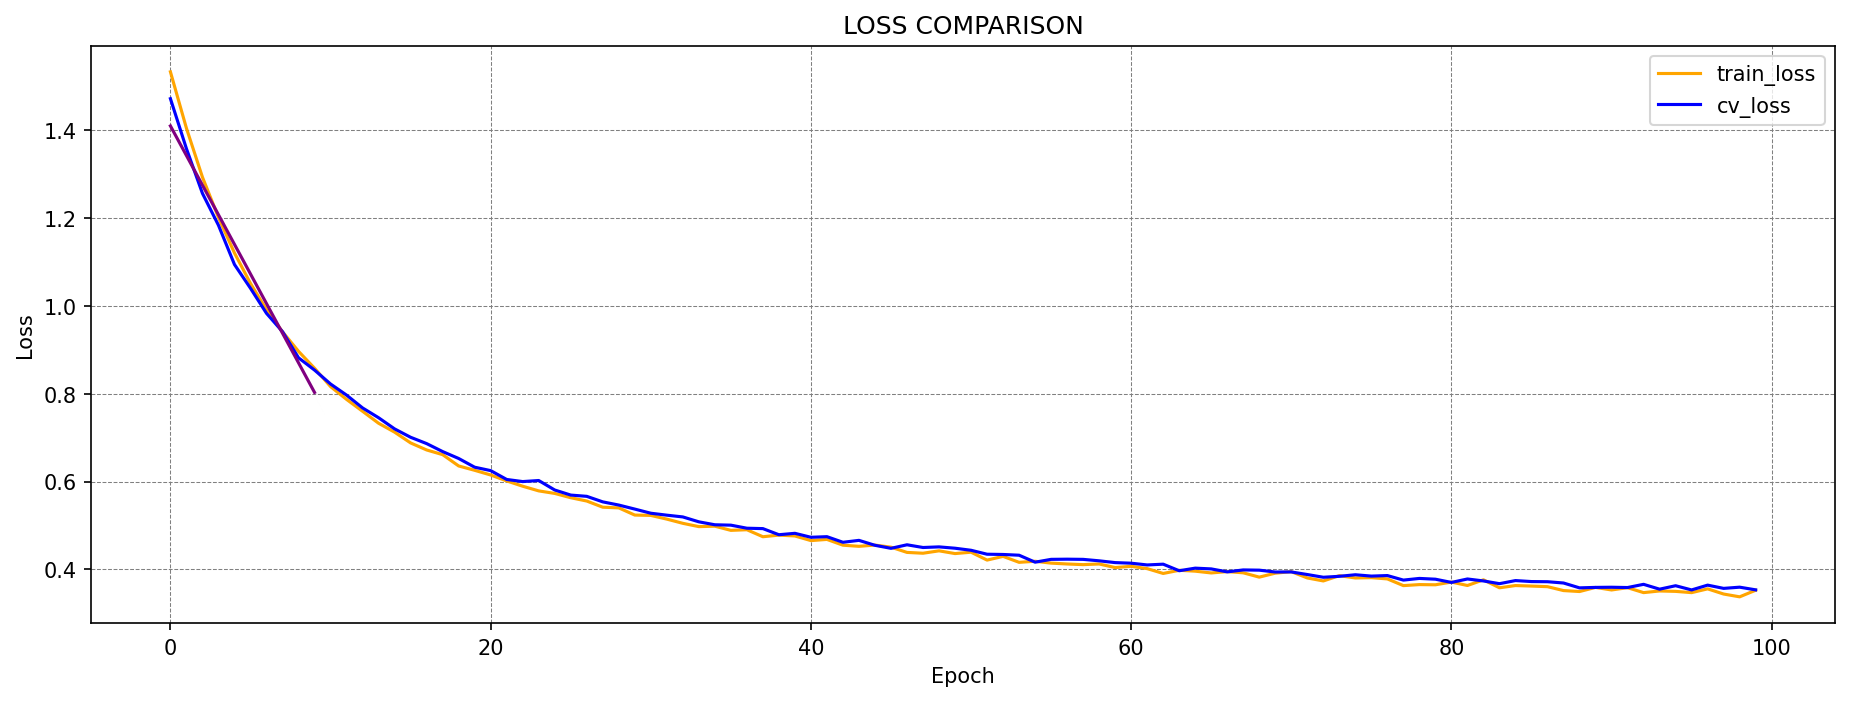

In [38]:
fig = plt.figure(figsize=[15, 5], dpi=150)
plt.plot(np.arange(len(model.history[loss])), model.history['train_loss'], color='orange', label='train_loss')
plt.plot(np.arange(len(model.history[loss])), model.history['cv_loss'], color='blue', label='cv_loss')
plt.title('LOSS COMPARISON')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(linewidth='.5', linestyle='--', color='gray')
polyfit_line = arange(period2 - period) * (-0.06747818) + 1.41036015
plt.plot(arange(period2 - period), polyfit_line, color='purple', label='cv_loss')

# <font color='orange'>STUDY ON THE THREE DIFFERENT SIZES OF EFFNET MODELS</font>

In [20]:
import pickle
models = [
    model_setup.EffNetB0(name='b0'),
    model_setup.EffNetB3(name='b3'),
    model_setup.EffNetB4(name='b4')
]

MODEL_HISTORY=[]
MODEL_CHECKPOINT=[]
MODEL_HISTORY.append('./saved_models/EffNet_b0/HISTORY_EfficientNetB0_LR0.005_BS32_Classes5.pkl')
MODEL_HISTORY.append('./saved_models/EffNet_b3/HISTORY_EfficientNetB3_LR0.005_BS32_Classes5.pkl')
MODEL_HISTORY.append('./saved_models/EffNet_b4/HISTORY_EfficientNetB4_LR0.005_BS32_Classes5.pkl')

for index, history in enumerate(MODEL_HISTORY):
    with open(history, 'rb') as f:
        history_dict = pickle.load(f)
    models[index].import_history(history_dict=history_dict)

{'train_loss': [1.5336049089431762,
  1.4050787715911865,
  1.2935875673294068,
  1.2017600107192994,
  1.1207966666221618,
  1.0514921231269836,
  0.9913441419601441,
  0.9412892088890076,
  0.8966883058547974,
  0.8581710610389709,
  0.8163615169525147,
  0.7871613054275512,
  0.760095808506012,
  0.7327716555595398,
  0.7125173420906067,
  0.6879731063842773,
  0.671957206249237,
  0.6612736942768097,
  0.6355042538642883,
  0.6255737946033478,
  0.6149187605381012,
  0.6014060609340668,
  0.5893191184997558,
  0.5786932878494263,
  0.5728955142498017,
  0.5631074781417846,
  0.5555593116283417,
  0.5415332851409912,
  0.5399501242637634,
  0.5236016516685486,
  0.5227746098041535,
  0.5143729231357574,
  0.5047963535785676,
  0.49725395488739016,
  0.49823822140693663,
  0.48874983286857604,
  0.4901683130264282,
  0.4742150206565857,
  0.4779145803451538,
  0.47595618534088135,
  0.4654041893482208,
  0.4681194109916687,
  0.4549398715496063,
  0.4523741555213928,
  0.455210651159

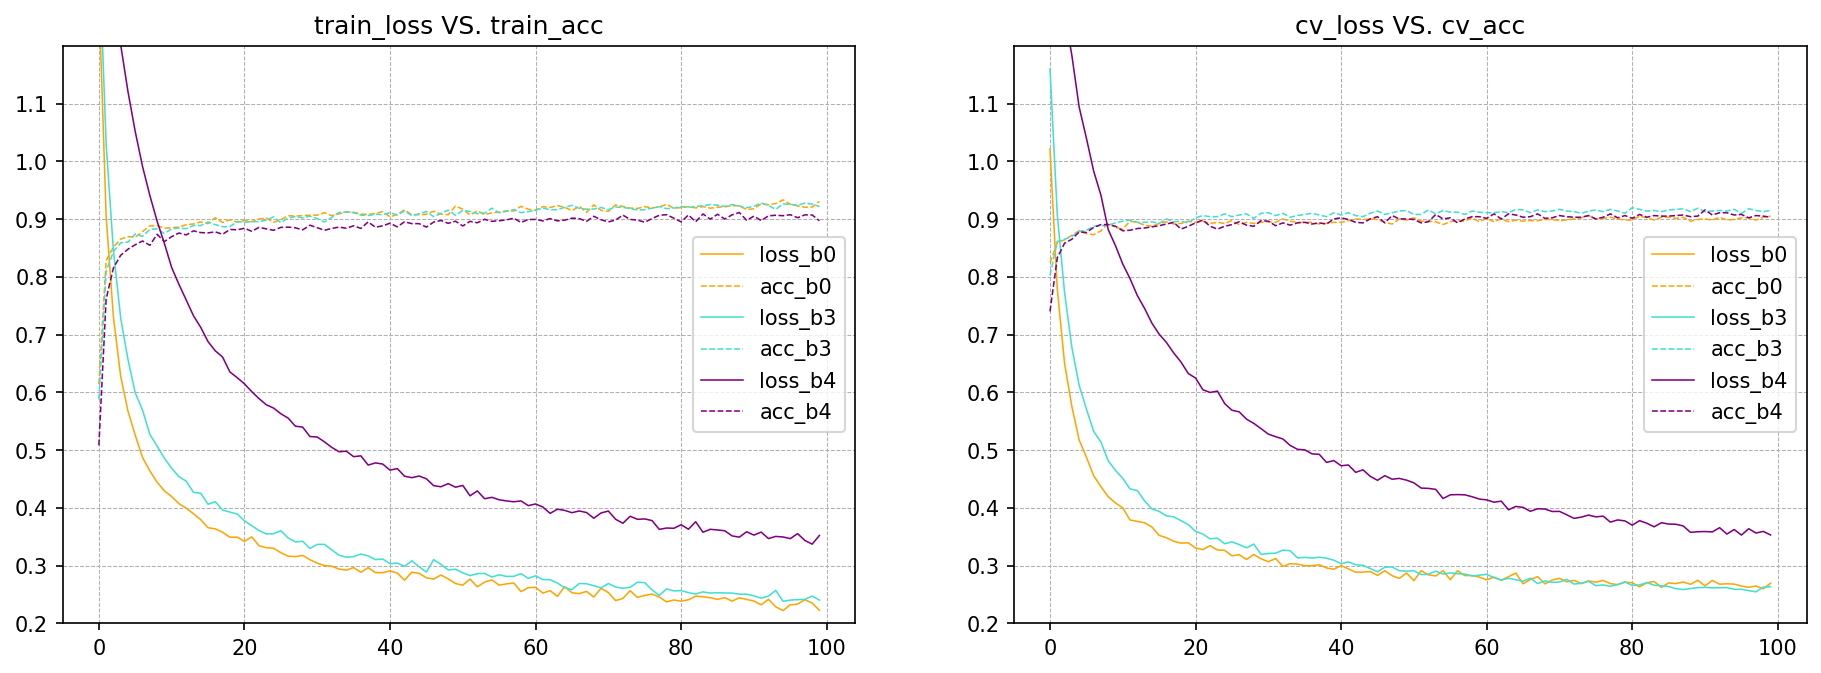

In [32]:
import matplotlib.pyplot as plt
metrics = [('train_loss', 'train_acc'),
           ('cv_loss', 'cv_acc')]
colors = ['orange', 'turquoise', 'purple']

fig = plt.figure(figsize=[15, 5], dpi=150)
for index, (loss, acc) in enumerate(metrics):
    fig.add_subplot(1, 2, index + 1)
    for model, color in zip(models, colors):
        plt.plot(
            np.arange(len(model.history[loss])),
            model.history[loss],
            label=f'loss_{model.name}',
            color=color,
            linewidth = 0.75,
        )
        plt.plot(
            np.arange(len(model.history[loss])),
            model.history[acc],
            label = f'acc_{model.name}',
            color=color,
            linewidth = 0.75,
            linestyle='--'
        )
    plt.legend()
    plt.title(f'{loss } VS. {acc}')
    plt.yticks(np.arange(0.2, 1.2, 0.1))
    plt.ylim(0.2, 1.2)
    plt.grid(linestyle='--', linewidth=0.5)
plt.savefig(MODEL_FOLDER / 'loss_acc_history.jpg')